In [1]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 621 (delta 166), reused 143 (delta 89), pack-reused 393 (from 1)
Receiving objects: 100% (621/621), 30.17 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/ELENA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.6 MB/s eta 0:00:00


In [2]:
import sys
import os
from pathlib import Path
import numpy as np
import time

# Get the directory of the current script
script_dir = Path(os.getcwd()).resolve()

# Add the src directory to the Python path
sys.path.append(str(Path(script_dir / '../src').resolve()))

figure_dir = '../data/processed/plots/manual/'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [3]:
def g_roll(lambda_):
    return ( ((16 * np.pi**2 * lambda_)/3) * (1 - lambda_ * (5 + 2*np.log(2) )/(8 * np.pi**2) ) )**(1/4)

In [4]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [5]:
%%writefile custom_model.py
"""
custom_model.py

CosmoTransitions-style framework + Abelian Higgs implementation.

This file provides:

1) GenericCTModel
   - Generic CosmoTransitions model where you plug:
       * V0_fun(X)
       * boson_fun(X,T) -> (M2, dof, c)
       * fermion_fun(X) -> (M2, dof)
       * optional Vct_fun(X)
       * optional Vcw_fun(X)      (hand "on-shell" CW like your 2nd code)
       * optional Vring_fun(X,T)  (custom daisy like your 2nd code)
   - Daisy schemes:
       0: none
       1: Parwani (use bosonsT in V1T)
       2: Arnold-Espinosa/Carrington (standard ring term, stable clipping)
       3: Custom (matches your 2nd code): V1T(bosons0) + Vring_fun(X,T)
   - Includes stable guards (NaN/Inf barrier).
   - Includes temperature derivatives: dVdT and d2VdT2 (so GWparams.cs2 works).

2) AbelianHiggsOnShell
   - Abelian Higgs (1 complex scalar + U(1) gauge) but tuned to match your 2nd code more tightly:
       * use_ct_cw=False -> use a hand on-shell-like CW (Vcw_on_shell)
       * daisyType=3     -> V1T(bosons0) + VDaisy_on_shell (Bessel kv structure)
       * thermal coefficients: scalar cS = λ/2 + g^2Y^2/4; gauge-longitudinal uses kv(2, ...)
   - Still exposes DVtot, gradV, dVdT, d2VdT2, approxZeroTMin.

Notes:
- For "tight match" to your 2nd code results use:
    m = AbelianHiggsOnShell(..., use_ct_cw=False, daisyType=3)
- For standard CT behavior use:
    m = AbelianHiggsOnShell(..., use_ct_cw=True,  daisyType=2)

"""

import numpy as np
from scipy.special import kv

from cosmoTransitions import generic_potential, helper_functions


# -------------------------
# Small stability utilities
# -------------------------
def _as_float_array(x):
    return np.asanyarray(x, dtype=float)

def _as_float_scalar(x):
    return float(np.asanyarray(x, dtype=float))

def _clip_m2_nonneg(m2):
    return np.maximum(np.asanyarray(m2, dtype=float), 0.0)

def _finite_or_big(y, big=1e300):
    """
    Replace non-finite values with a huge number (barrier for minimizers).
    Works for scalar or array outputs.
    """
    y = np.asanyarray(y)
    if np.isscalar(y) or y.shape == ():
        return y if np.isfinite(y) else big
    out = y.copy()
    mask = ~np.isfinite(out)
    if np.any(mask):
        out[mask] = big
    return out

def _adaptive_T_step(T, eps_abs=1e-6, eps_rel=1e-3, Tmin_step=1e-6):
    T = float(T)
    return max(float(eps_abs), float(eps_rel) * abs(T), float(Tmin_step))

def kdelta(a, b):
    """
    Kronecker-like delta used in your 2nd code to regularize logs.
    Works with scalars or arrays.
    """
    a = np.asanyarray(a)
    return (a == b).astype(float)

# "Real unit" used in your 2nd code
Re1 = complex(1.0, 0.0)

# constant used in your 2nd code
ciZp = 1.0 / 3.0


# --------------------------------
# Generic CT-style engine (improved)
# --------------------------------
class GenericCTModel(generic_potential.generic_potential):
    """
    Generic CosmoTransitions model with optional hooks for "on-shell" CW and custom daisies.

    You supply:
      - V0_fun(X)
      - boson_fun(X,T) -> (M2, dof, c)
      - fermion_fun(X) -> (M2, dof)
      - Vct_fun(X)      (optional)
      - Vcw_fun(X)      (optional)  # hand CW, used if use_ct_cw=False
      - Vring_fun(X,T)  (optional)  # custom ring, used if daisyType=3

    Daisy types:
      0: no daisies, V1T(bosons0)
      1: Parwani,    V1T(bosonsT)
      2: AE/Carrington ring built from bosons0/bosonsT (stable clipping)
      3: Custom:     V1T(bosons0) + Vring_fun(X,T)    (matches your 2nd code pattern)

    CW:
      use_ct_cw=True  -> add CT V1(bosons0,fermions) + Vct
      use_ct_cw=False -> add Vcw_fun(X) + Vct
    """

    def init(
        self,
        Ndim,
        V0_fun,
        boson_fun,
        fermion_fun=None,
        Vct_fun=None,
        Vcw_fun=None,
        Vring_fun=None,
        use_ct_cw=True,
        xstep=1e-3,
        Tstep_abs=1e-4,
        Tstep_rel=1e-3,
        Tmin_step=1e-6,
        daisyType=2,
        deriv_order=2,
    ):
        self.Ndim = int(Ndim)
        if V0_fun is None or boson_fun is None:
            raise ValueError("GenericCTModel requires at least V0_fun and boson_fun.")

        self._V0_fun = V0_fun
        self._boson_fun = boson_fun
        self._fermion_fun = fermion_fun if fermion_fun is not None else (lambda X: (0.0, 0.0))
        self._Vct_fun = Vct_fun if Vct_fun is not None else (lambda X: 0.0)

        self._Vcw_fun = Vcw_fun if Vcw_fun is not None else (lambda X: 0.0)
        self._Vring_fun = Vring_fun  # may be None

        self.use_ct_cw = bool(use_ct_cw)

        self.x_eps = float(xstep)
        self.T_eps_abs = float(Tstep_abs)
        self.T_eps_rel = float(Tstep_rel)
        self.Tmin_step = float(Tmin_step)

        self.daisyResum = int(daisyType)
        self.deriv_order = int(deriv_order)

    # CT-required
    def V0(self, X):
        return self._V0_fun(_as_float_array(X))

    def Vct(self, X):
        return self._Vct_fun(_as_float_array(X))

    def boson_massSq(self, X, T):
        return self._boson_fun(_as_float_array(X), _as_float_scalar(T))

    def fermion_massSq(self, X):
        return self._fermion_fun(_as_float_array(X))

    def Vtot(self, X, T, include_radiation=True):
        X = _as_float_array(X)
        T = _as_float_array(T)

        fermions = self.fermion_massSq(X)
        bosons0 = self.boson_massSq(X, 0.0 * T)

        y = self.V0(X)

        # CW
        if self.use_ct_cw:
            y = y + self.V1(bosons0, fermions) + self.Vct(X)
        else:
            y = y + self._Vcw_fun(X) + self.Vct(X)

        # Thermal + daisies
        if self.daisyResum == 0:
            y = y + self.V1T(bosons0, fermions, T, include_radiation)

        elif self.daisyResum == 1:
            bosonsT = self.boson_massSq(X, T)
            y = y + self.V1T(bosonsT, fermions, T, include_radiation)

        elif self.daisyResum == 2:
            # Standard AE ring term, stable clipping to keep real
            bosonsT = self.boson_massSq(X, T)
            m20, nb, _ = bosons0
            m2T, _, _ = bosonsT

            m20c = _clip_m2_nonneg(m20)
            m2Tc = _clip_m2_nonneg(m2T)

            Vring = -(T / (12.0 * np.pi)) * np.sum(
                nb * (np.power(m2Tc, 1.5) - np.power(m20c, 1.5)),
                axis=-1
            )
            y = y + self.V1T(bosons0, fermions, T, include_radiation) + Vring

        elif self.daisyResum == 3:
            # Match your 2nd code pattern: V1T(bosons0) + custom VDaisy
            y = y + self.V1T(bosons0, fermions, T, include_radiation)
            if self._Vring_fun is None:
                raise ValueError("daisyType=3 requires Vring_fun (custom VDaisy).")
            y = y + self._Vring_fun(X, T)

        else:
            raise ValueError("daisyType must be 0, 1, 2, or 3.")

        return _finite_or_big(y)

    def DVtot(self, X, T):
        X = _as_float_array(X)
        return self.Vtot(X, T, include_radiation=False) - self.Vtot(X * 0.0, T, include_radiation=False)

    def gradV(self, X, T):
        try:
            f = self._gradV
        except AttributeError:
            self._gradV = helper_functions.gradientFunction(
                self.Vtot, self.x_eps, self.Ndim, self.deriv_order
            )
            f = self._gradV

        T = np.asanyarray(T)[..., np.newaxis, np.newaxis]
        return f(X, T, False)

    # -------------------------------
    # Temperature derivatives (stable)
    # -------------------------------
    def dVdT(self, X, T, include_radiation=True, include_SM=False, units="GeV"):
        """
        dV/dT via adaptive finite differences.
        GWparams.cs2 expects: m.dVdT(phi, T, include_radiation=True, include_SM=True, units=...)
        """
        X = _as_float_array(X)
        T = float(T)

        h = _adaptive_T_step(T, eps_abs=self.T_eps_abs, eps_rel=self.T_eps_rel, Tmin_step=self.Tmin_step)

        if T <= h:
            V0 = self.Vtot(X, 0.0, include_radiation=include_radiation)
            V1 = self.Vtot(X, h,   include_radiation=include_radiation)
            d = (V1 - V0) / h
        else:
            Vm = self.Vtot(X, T - h, include_radiation=include_radiation)
            Vp = self.Vtot(X, T + h, include_radiation=include_radiation)
            d = (Vp - Vm) / (2.0 * h)

        if include_SM:
            # Try temperatures.s_SM first (your earlier code style), fallback to utils.s_SM (your 2nd code)
            s_sm = 0.0
            try:
                import temperatures as temp
                try:
                    s_sm = temp.s_SM(T, units=units)
                except TypeError:
                    s_sm = temp.s_SM(T)
            except Exception:
                try:
                    from utils import s_SM as s_sm_fun
                    s_sm = s_sm_fun(T, units=units)
                except Exception:
                    s_sm = 0.0
            d = d - s_sm

        return d

    def d2VdT2(self, X, T, include_radiation=True, include_SM=False, units="GeV"):
        """
        d^2V/dT^2 via adaptive finite differences.
        We do NOT add unknown SM second-derivative pieces (consistent with your earlier stabilized code).
        """
        X = _as_float_array(X)
        T = float(T)

        h = _adaptive_T_step(T, eps_abs=self.T_eps_abs, eps_rel=self.T_eps_rel, Tmin_step=self.Tmin_step)

        if T <= 2.0 * h:
            V0  = self.Vtot(X, 0.0,      include_radiation=include_radiation)
            Vh  = self.Vtot(X, h,        include_radiation=include_radiation)
            V2h = self.Vtot(X, 2.0 * h,  include_radiation=include_radiation)
            val = (V2h - 2.0 * Vh + V0) / (h * h)
        else:
            Vm = self.Vtot(X, T - h, include_radiation=include_radiation)
            Vc = self.Vtot(X, T,     include_radiation=include_radiation)
            Vp = self.Vtot(X, T + h, include_radiation=include_radiation)
            val = (Vp - 2.0 * Vc + Vm) / (h * h)

        return val


# ---------------------------------------------------------
# Abelian Higgs "tight match" wrapper (like your 2nd code)
# ---------------------------------------------------------
class AbelianHiggsOnShell(GenericCTModel):
    """
    Abelian Higgs (1 complex scalar + U(1) gauge) tuned to match your 2nd code:

    - V0 = 1/2 m0^2 φ^2 + 1/4 λ φ^4 with m0^2 = -λ v^2
    - Vcw_on_shell: hand formula (your 2nd code style)
    - VDaisy_on_shell: custom daisy (your 2nd code style with kv)
    - boson spectrum: [H, G, A_T, A_L], dof [1,1,2,1]
    - thermal coefficients:
        scalar: cS = λ/2 + g^2Y^2/4   (your 2nd code)
        longitudinal gauge: cDP via kv(2, ...)
    """

    def init(
        self,
        vev=500.0,
        lambda_=2.4e-3,
        g=0.54,
        Y=1.0,
        xstep=5e-5,
        Tstep_abs=1e-4,
        Tstep_rel=1e-3,
        Tmin_step=1e-6,
        deriv_order=2,
        use_ct_cw=False,   # False -> use on-shell CW like your 2nd code
        daisyType=3,       # 3 -> V1T(bosons0) + VDaisy_on_shell like your 2nd code
    ):
        self.vev = float(vev)
        self.lam = float(lambda_)
        self.g = float(g)
        self.Y = float(Y)

        self.m0sq = -self.lam * (self.vev ** 2)

        def V0_fun(X):
            X = _as_float_array(X)
            phi = X[..., 0]
            return 0.5 * self.m0sq * phi * phi + 0.25 * self.lam * (phi ** 4)

        def Vcw_on_shell(X):
            """
            Hand CW in your 2nd code style.
            There, muphi = w*sqrt(lambda). Here w -> vev.
            """
            X = np.asanyarray(X, dtype=float)
            phi = X[..., 0]

            w0 = self.vev
            lambdaphi = self.lam
            gZp = self.g * self.Y

            muphi = w0 * np.sqrt(lambdaphi)

            term = (
                6.0 * gZp**4 * muphi**2 * phi**2 / lambdaphi
                - 4.0 * muphi**2 * (muphi**2 - 3.0 * lambdaphi * phi**2)
                + 3.0 * gZp**4 * phi**4 * (-1.5 + np.log(lambdaphi * phi**2 / muphi**2 + kdelta(phi, 0.0)))
                + 0.5 * (muphi**2 - 3.0 * lambdaphi * phi**2) ** 2
                * (-3.0 + 2.0 * np.log(0.5 * np.abs(1.0 - 3.0 * lambdaphi * phi**2 / muphi**2)
                                       + kdelta(3.0 * lambdaphi * phi**2 - muphi**2, 0.0)))
                + (muphi**2 - lambdaphi * phi**2) ** 2
                * (-1.5 + np.log(0.5 * np.abs(1.0 - lambdaphi * phi**2 / muphi**2)
                                 + kdelta(lambdaphi * phi**2 - muphi**2, 0.0)))
            )
            return (1.0 / (64.0 * np.pi**2)) * term

        def VDaisy_on_shell(X, T):
            """
            Custom daisy (VDaisy) in your 2nd code style.
            Uses complex powers + np.real for tight matching.
            """
            w0 = self.vev
            lambdaphi = self.lam
            gZp = self.g * self.Y

            X = np.asanyarray(X, dtype=float)
            phi = X[..., 0]
            T = np.asanyarray(T, dtype=float)

            muphi = w0 * np.sqrt(lambdaphi)

            # mimic your code: if T==0 -> 1e-3 inside daisy
            if isinstance(T, np.ndarray):
                T_eff = T.copy()
                T_eff[T_eff == 0.0] = 1e-3
            else:
                T_eff = 1e-3 if float(T) == 0.0 else float(T)

            m2_gold  = lambdaphi * phi**2 - muphi**2
            m2_higgs = 3.0 * lambdaphi * phi**2 - muphi**2
            m2_dp    = gZp**2 * phi**2

            prefactor = T_eff / (12.0 * np.pi)

            first_terms = (Re1 * m2_dp) ** 1.5 + (Re1 * m2_gold) ** 1.5 + (Re1 * m2_higgs) ** 1.5

            first_mod_term = Re1 * (
                m2_dp
                + 0.5 * ciZp * gZp**2 * T_eff**2
                * (m2_dp / T_eff**2 * kv(2, Re1 * gZp * phi / T_eff + kdelta(phi, 0.0))
                   + 2.0 * kdelta(phi, 0.0))
            )
            first_mod_term = first_mod_term ** 1.5

            second_mod_term = Re1 * (m2_gold + 0.25 * gZp**2 * T_eff**2 + 0.5 * lambdaphi * T_eff**2)
            second_mod_term = second_mod_term ** 1.5

            third_mod_term = Re1 * (m2_higgs + 0.25 * gZp**2 * T_eff**2 + 0.5 * lambdaphi * T_eff**2)
            third_mod_term = third_mod_term ** 1.5

            return np.real(prefactor * (first_terms - first_mod_term - second_mod_term - third_mod_term))

        def boson_fun(X, T):
            """
            Return (M2, dof, c) for [H, G, A_T, A_L].

            Thermal pieces match your 2nd code conventions:
              cS  = λ/2 + g^2Y^2/4
              cDP from kv structure
            """
            X = np.asanyarray(X, dtype=float)
            phi = X[..., 0]
            T = float(np.asanyarray(T, dtype=float))

            gZp = self.g * self.Y

            # tree
            mH2 = self.m0sq + 3.0 * self.lam * phi**2
            mG2 = self.m0sq + 1.0 * self.lam * phi**2
            mA2 = (gZp**2) * phi**2

            # scalar thermal mass coefficient (your 2nd code)
            cS = self.lam / 2.0 + (gZp**2) / 4.0

            # gauge longitudinal correction coefficient (your 2nd code)
            if T > 0.0:
                mDP2 = mA2
                cDP = np.real(
                    0.5 * ciZp * gZp**2
                    * (mDP2 / T**2 * kv(2, Re1 * gZp * phi / T + kdelta(phi, 0.0))
                       + 2.0 * kdelta(phi, 0.0))
                )
            else:
                cDP = 0.0

            if T > 0.0:
                mH2_eff = mH2 + cS * T**2
                mG2_eff = mG2 + cS * T**2
                mAT2_eff = mA2
                mAL2_eff = mA2 + cDP * T**2
            else:
                mH2_eff, mG2_eff = mH2, mG2
                mAT2_eff, mAL2_eff = mA2, mA2

            M2 = np.stack([mH2_eff, mG2_eff, mAT2_eff, mAL2_eff], axis=-1)
            dof = np.array([1.0, 1.0, 2.0, 1.0])
            c   = np.array([3.0/2.0, 3.0/2.0, 5.0/6.0, 5.0/6.0])
            return M2, dof, c

        def fermion_fun(X):
            return 0.0, 0.0

        super().init(
            Ndim=1,
            V0_fun=V0_fun,
            boson_fun=boson_fun,
            fermion_fun=fermion_fun,
            Vct_fun=None,
            Vcw_fun=Vcw_on_shell,
            Vring_fun=VDaisy_on_shell,
            use_ct_cw=use_ct_cw,
            xstep=xstep,
            Tstep_abs=Tstep_abs,
            Tstep_rel=Tstep_rel,
            Tmin_step=Tmin_step,
            daisyType=daisyType,
            deriv_order=deriv_order,
        )

    def approxZeroTMin(self):
        return [np.array([self.vev], dtype=float)]


# Compatibility alias (if your old scripts import DarkPhotonOnShellCT)
DarkPhotonOnShellCT = AbelianHiggsOnShell

Writing custom_model.py


In [8]:
import numpy as np
import sys, importlib

if 'custom_model' in sys.modules:
    importlib.reload(sys.modules['custom_model'])

# ✅ Use the Abelian-Higgs tight-match class we just wrote
from custom_model import AbelianHiggsOnShell

# Map your old parameter names -> Abelian Higgs names
w = 500.0
lambdaf = 1.65e-3
gX = 0.54
description = "BP1"

dp = AbelianHiggsOnShell(
    vev=w,              # w -> vev
    lambda_=lambdaf,    # lambdaf -> lambda_
    g=gX,               # gX -> g
    Y=1.0,              # same as your code #2
    daisyType=3,        # matches your second code's special mode (V1T(bosons0)+VDaisy)
    use_ct_cw=False,    # "on-shell" CW like your second code's CV_method="on-shell"
    xstep=5e-5,
    Tstep_abs=5e-5,
)

phi_test = 10.0
T_test = 200.0

V  = lambda phi, T: dp.DVtot(np.atleast_1d(phi).reshape(-1,1), T)
dV = lambda phi, T: dp.gradV(np.atleast_1d(phi).reshape(-1,1), T)[..., 0]

print("DV(10,200) =", V(phi_test, T_test))
print("dV/dphi(10,200) =", dV(phi_test, T_test))

DV(10,200) = [130644.60508084]
dV/dphi(10,200) = [26003.953125]


In [9]:
vev=w

In [10]:
units="MeV"

In [11]:
from temperatures import find_T_min, find_T_max, refine_Tmin

T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(V, dV, precision= 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, tmax=2.5 * vev)
T_min, vevs_min, false_min_tmin = find_T_min(V, dV, tmax=T_max, precision = 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, max_min_vals = max_min_vals)

if T_max is not None and T_min is not None:
    maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
elif T_max is not None:
    maxvev = np.max(vevs_max)
elif T_min is not None:
    maxvev = np.max(vevs_min)
else:
    maxvev = None

T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision = 6) if T_min is not None else None

print(f"T_max = {T_max:.6e} {units}")
print(f"T_min = {T_min:.6e} {units}")


T_max = 8.482500e+01 MeV
T_min = 1.149737e+01 MeV


In [12]:
T_max, vevs_max, max_min_vals, false_min_tmax

(np.float64(84.82499999999999),
 array([485.95833231, 474.0492604 , 472.21680596, 472.07568042]),
 [239.29086544283933, 472.0756804232009],
 [0, 0])

In [13]:
T_min, vevs_min, false_min_tmin

(np.float64(11.49736886668905), array([499.98459805]), [0, 0])

In [14]:
maxvev

np.float64(499.9845980461811)

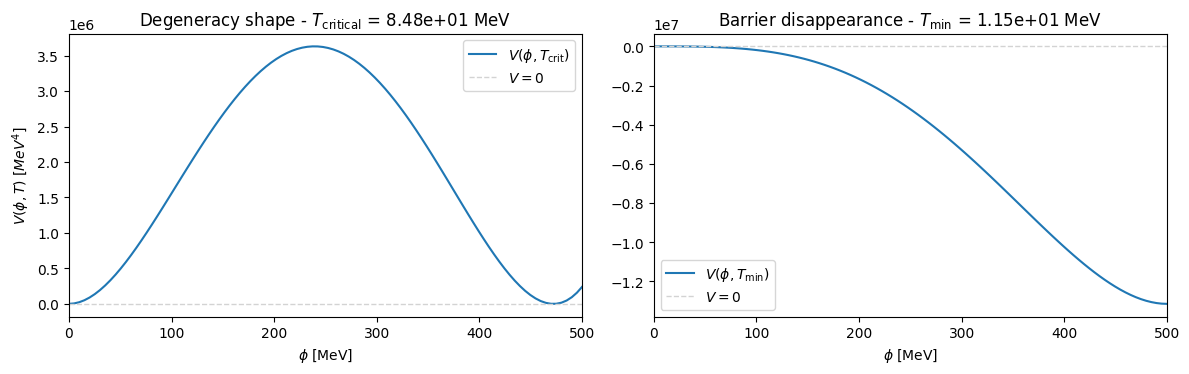

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
phi= np.linspace(0, 1*vev, 100)
if T_max is not None: v_max = V(phi, T_max)
if T_min is not None: v_min = V(phi, T_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if T_max is not None:
    v_max = V(phi, T_max)
    axes[0].plot(phi, v_max, label = '$V(\\phi, T_{\\mathrm{{crit}}})$')
    axes[0].set_title(f'Degeneracy shape - $T_{{\\mathrm{{critical}}}}$ = {T_max:.2e} {units}')
    axes[0].set_xlim(phi[0], phi[-1])
    axes[0].set_ylabel(f"$V(\\phi, T)$ $[{units}^{4}]$")

if T_min is not None:
    v_min = V(phi, T_min)
    axes[1].plot(phi, v_min, label= '$V(\\phi, T_{\\mathrm{{min}}})$')
    axes[1].set_title(f'Barrier disappearance - $T_{{\\mathrm{{min}}}}$ = {T_min:.2e} {units}')
    axes[1].set_xlim(phi[0], phi[-1])

for ax in axes:
    ax.set_xlabel(f"$\\phi$ [{units}]")
    ax.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1, label = "$V = 0$")
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from espinosa import Vt_vec

true_vev = {}
S3overT = {}
V_min_value = {}
phi0_min = {}
V_exit = {}
false_vev = {}

def action_over_T(T, c_step_phi = 1e-3, precision = 1e-3):
    instance = Vt_vec(T, V, dV, step_phi = c_step_phi, precision = precision, vev0 = maxvev, ratio_vev_step0=50)
    if instance.barrier:
        true_vev[T] = instance.true_min
        false_vev[T] = instance.phi_original_false_vev
        S3overT[T] = instance.action_over_T
        V_min_value[T] = instance.min_V
        phi0_min[T] = instance.phi0_min
        V_exit[T] = instance.V_exit
        return instance.action_over_T
    else:
        return None

In [17]:
n_points = 100
temperatures = np.linspace(T_min, T_max, n_points)
action_vec = np.vectorize(action_over_T)

start_time = time.time()
action_vec(temperatures)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

temperatures = np.array([T for T in temperatures if T in S3overT])

Elapsed time: 4.60 seconds


<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\ '
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\ '
<>:32: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\ '
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\ '
<>:32: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-559/3740054380.py:12: SyntaxWarning: invalid escape sequence '\

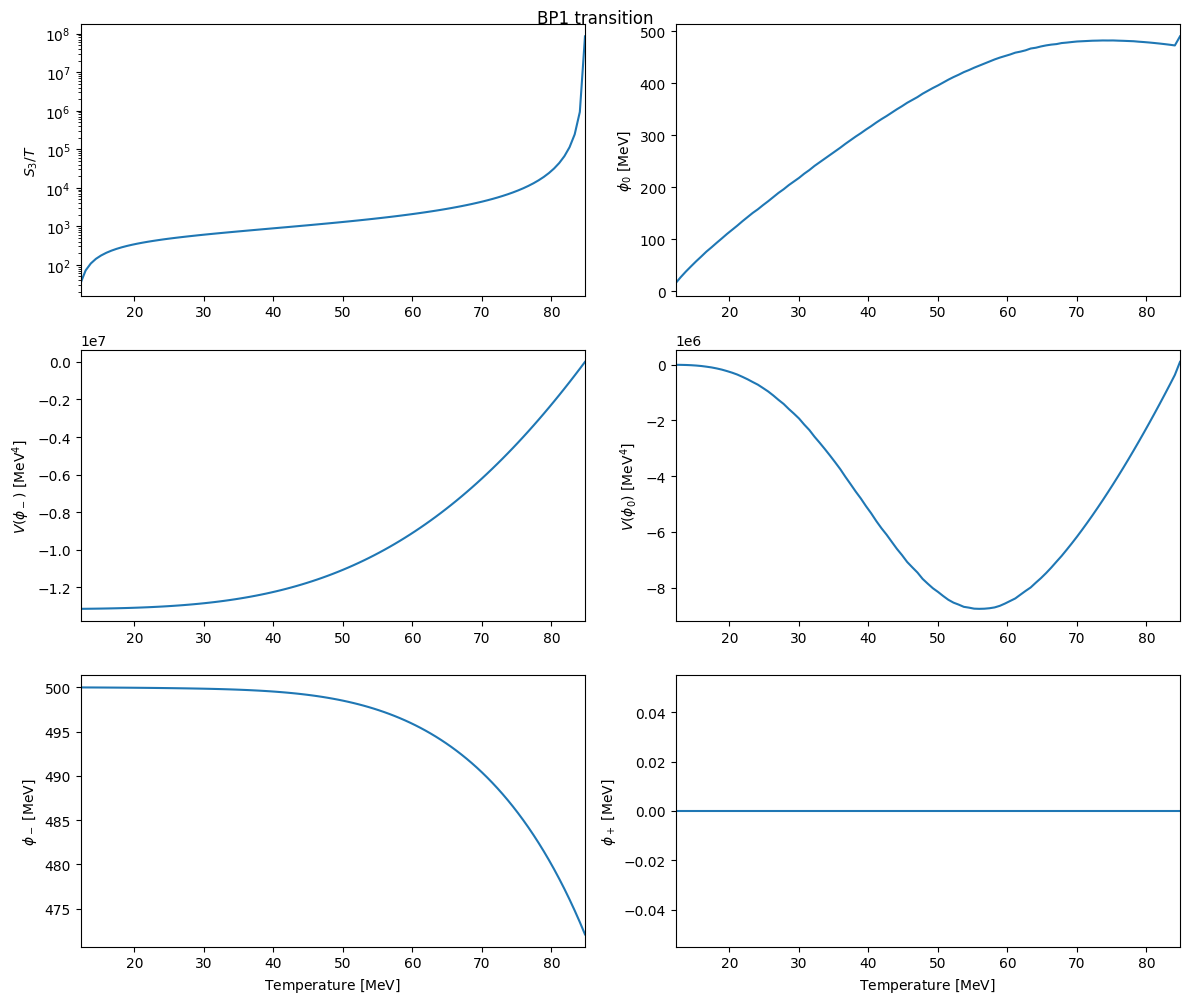

Minimum of the action at T = 1.22e+01 MeV


In [18]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(temperatures, [S3overT[T] for T in temperatures])
#axes[0, 0].set_title('$S_3/T$')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('$S_3/T$')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(temperatures, [phi0_min[T] for T in temperatures])
#axes[0, 1].set_title('$\phi_{0,\mathrm{min}}$')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f"$\phi_0\ \mathrm{{[{units}]}}$")

axes[1, 0].plot(temperatures, [V_min_value[T] for T in temperatures])
#axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f"$V(\phi_-)\ \mathrm{{[{units}^4]}}$") # (f'$V_{{\\mathrm{{min}}}}\ [{units}^4]$')

axes[1, 1].plot(temperatures, [V_exit[T] for T in temperatures])
#axes[1, 1].set_title('$V(\phi_{0,\mathrm{min}})$')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f"$V(\phi_0)\ \mathrm{{[{units}^4]}}$") # (f'$V_{{\\mathrm{{exit}}}}\ [{units}^4]$')

axes[2, 0].plot(temperatures, [true_vev[T] for T in temperatures])
#axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 0].set_ylabel(f"$\phi_-\ \mathrm{{[{units}]}}$") # (f'$\\phi_{{\\mathrm{{true}}}}$ [{units}]')

axes[2, 1].plot(temperatures, [false_vev[T] for T in temperatures])
#axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 1].set_ylabel(f"$\phi_+\ \mathrm{{[{units}]}}$") # (f'$\\phi_{{\\mathrm{{false}}}}$ [{units}]')

for ax in axes.flatten():
    ax.set_xlim(temperatures[0], temperatures[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"action_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Minimum of the action at T = {temperatures[np.argmin([S3overT[T] for T in temperatures])]:.2e} {units}")

In [19]:
from utils import interpolation_narrow
from temperatures import compute_logP_f, N_bubblesH, R_sepH

is_physical = True

def is_increasing(arr):
    return np.all(arr[:-1] <= arr[1:])

counter = 0
while counter <= 1:
    if counter == 1:
        temperatures = np.linspace(np.nanmax([T_min, 0.95 * T_completion]), np.nanmin([T_max, 1.05 * T_nuc]), n_points, endpoint = True)
        action_vec(temperatures)
    logP_f, Temps, ratio_V, Gamma, H = compute_logP_f(dp, V_min_value, S3overT, v_w = 1, units = units, cum_method= 'None')
    RH, R = R_sepH(Temps, Gamma, logP_f, H, ratio_V)
    nH = N_bubblesH(Temps, Gamma, logP_f, H, ratio_V)
    mask_nH = ~np.isnan(nH)
    T_nuc = interpolation_narrow(np.log(nH[mask_nH]), Temps[mask_nH], 0)
    mask_Pf = ~np.isnan(logP_f)
    T_perc = interpolation_narrow(logP_f[mask_Pf], Temps[mask_Pf], np.log(0.71))
    T_completion = interpolation_narrow(logP_f[mask_Pf], Temps[mask_Pf], np.log(0.01))
    idx_compl = np.max([np.argmin(np.abs(Temps - T_completion)), 1])
    test_completion = np.array([logP_f[idx_compl - 1], logP_f[idx_compl], logP_f[idx_compl + 1]])
    test_completion = test_completion[~np.isnan(test_completion)]
    print(counter, T_completion, test_completion)
    print(is_increasing(test_completion))
    if not is_increasing(test_completion):
        T_completion = np.nan
    if counter == 1:
        d_dT_logP_f = np.gradient(logP_f, Temps)
        log_at_T_perc = interpolation_narrow(Temps, d_dT_logP_f, T_perc)
        ratio_V_at_T_perc = interpolation_narrow(Temps, ratio_V, T_perc)
        log_at_T_completion = interpolation_narrow(Temps, d_dT_logP_f, T_completion)
        ratio_V_at_T_completion = interpolation_narrow(Temps, ratio_V, T_completion)
        if ratio_V_at_T_perc > log_at_T_perc:
            is_physical = False
            print("\n *** The physical volume at percolation is not decreasing. The production of GW is questionable ***")
    counter += 1

milestones = [T_max, T_nuc, T_perc, T_completion, T_min]
milestones = [milestone for milestone in milestones if milestone is not None and not np.isnan(milestone)]
action_vec(milestones)

# This is just for plotting purposes
t_mil_min, t_mil_max = np.nanmin([T_completion, T_perc, T_nuc]), np.nanmax([T_completion, T_perc, T_nuc])
idx_min = max(np.argmin(np.abs(Temps - t_mil_min)), 0)
idx_max = min(np.argmin(np.abs(Temps - t_mil_max)), len(Temps) - 1)
idx_min = idx_min if Temps[idx_min] <= t_mil_min else idx_min - 1
idx_max = idx_max if Temps[idx_max] >= t_mil_max else idx_max + 1
mask = (Temps >= Temps[idx_min]) & (Temps <= Temps[idx_max]) if not np.isnan(t_mil_min) else Temps >= 0

print(f"\nT_nuc = {T_nuc:.6e} {units}")
print(f"T_perc = {T_perc:.6e} {units}")
print(f"T_completion = {T_completion:.6e} {units}\n")

/content/ELENA/src/temperatures.py:433: RuntimeWarning: divide by zero encountered in power
  return n**(-1/3) * H, n**(-1/3)
/tmp/ipython-input-559/2969552134.py:18: RuntimeWarning: divide by zero encountered in log
  T_nuc = interpolation_narrow(np.log(nH[mask_nH]), Temps[mask_nH], 0)


0 14.46010143773047 [-2.33276152e+12 -5.82120757e-02 -7.25028191e-15]
True
1 14.810471534338843 [-10.13903804  -3.56816527  -1.23450746]
True

T_nuc = 1.526647e+01 MeV
T_perc = 1.487031e+01 MeV
T_completion = 1.481047e+01 MeV



In [20]:
T_min

np.float64(11.49736886668905)

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\ '
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-559/3047059214.py:9: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_ylabel(f"$\mathrm{{[{units}^{{-1}}]}}$") #(f'$[{units}^{{-1}}]$')
/tmp/ipython-input-559/3047059214.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
/tmp/ipython-input-559/3047059214.py:24: SyntaxWarning: invalid escape sequence '\ '
  ax.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")


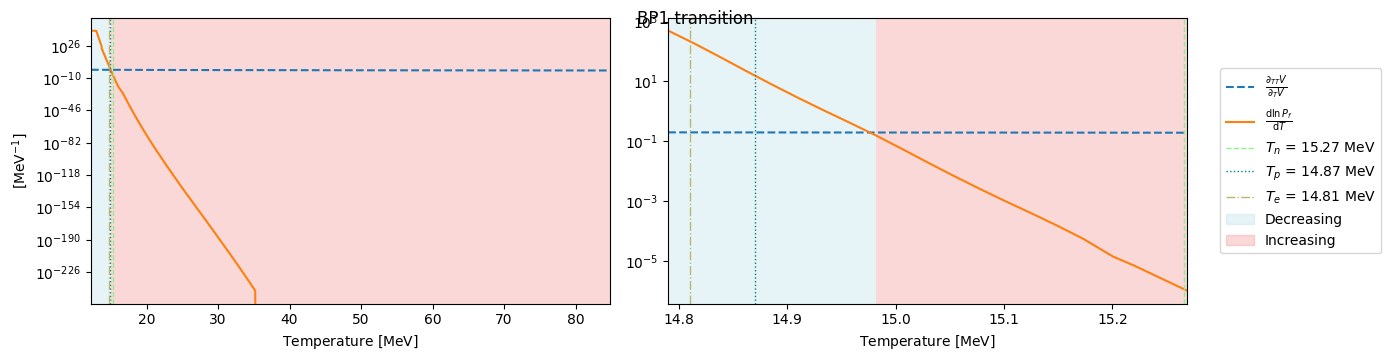

In [21]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# axes[0].plot(Temps, 3 / Temps, label = 'Bag model')
axes[0].plot(Temps, ratio_V, label = 'V_TT / V_T', linestyle='--')
axes[0].plot(Temps, d_dT_logP_f, label = 'd/dT log(P_f)')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(f"$\mathrm{{[{units}^{{-1}}]}}$") #(f'$[{units}^{{-1}}]$')

# axes[1].plot(Temps[mask], 3 / Temps[mask], label = 'Bag model')
axes[1].plot(Temps[mask], ratio_V[mask], label = r'$\frac{\partial_{TT} V}{\partial_T V}$', linestyle='--')
axes[1].plot(Temps[mask], d_dT_logP_f[mask], label = r'$\frac{\mathrm{d} \ln P_f}{\mathrm{d} T}$')

axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# Create the legend patches
decreasing_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='decreasing')
increasing_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='increasing')


for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}}$ = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}}$ = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}}$ = {T_completion:.2f} {units}')
    # ax.axhline(log_at_T_perc, color='lightgrey', linestyle='--', linewidth=1, label = f"d/dT log(P_f) = {log_at_T_perc:.2e}")
    # ax.axhline(ratio_V_at_T_perc, color='lightgreen', linestyle=':', linewidth=1, label = f"V_TT / V_T = {ratio_V_at_T_perc:.2e}")
    for i in range(len(Temps) - 1):
        if d_dT_logP_f[i] >= ratio_V[i]:
            ax.axvspan(Temps[i], Temps[i + 1], facecolor='lightblue', alpha=0.3)
        else:
            ax.axvspan(Temps[i], Temps[i + 1], facecolor='lightcoral', alpha=0.3)

handles, labels = axes[1].get_legend_handles_labels()
handles.extend([decreasing_patch, increasing_patch])
labels.extend(['Decreasing', 'Increasing'])
axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.suptitle(f'{description} transition', y=0.89)
plt.tight_layout()
plt.savefig(figure_dir + f"volume_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

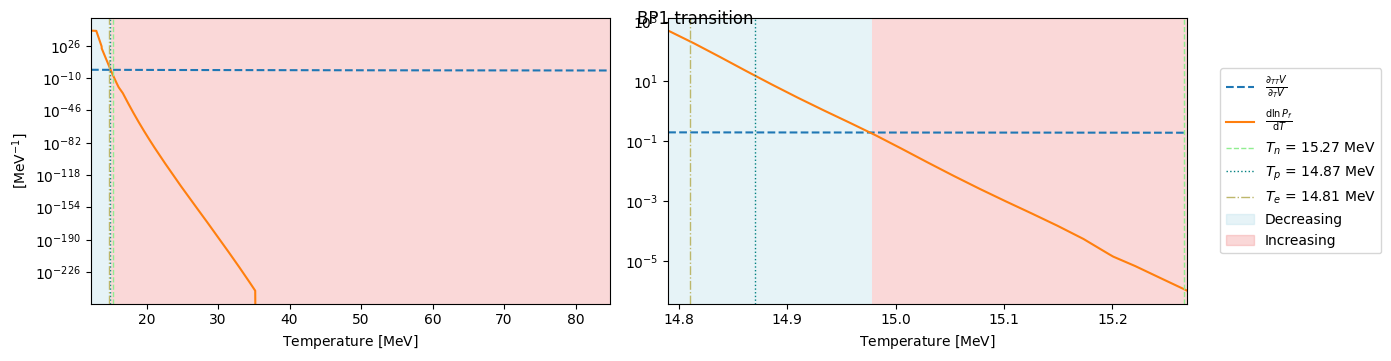

In [22]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot per il grafico intero
axes[0].plot(Temps, ratio_V, label = 'V_TT / V_T', linestyle='--')
axes[0].plot(Temps, d_dT_logP_f, label = 'd/dT log(P_f)')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(f"$\\mathrm{{[{units}^{{-1}}]}}$")

# Plot per la vista ingrandita
axes[1].plot(Temps[mask], ratio_V[mask], label = r'$\frac{\partial_{TT} V}{\partial_T V}$', linestyle='--')
axes[1].plot(Temps[mask], d_dT_logP_f[mask], label = r'$\frac{\mathrm{d} \ln P_f}{\mathrm{d} T}$')
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# Create the legend patches
decreasing_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='decreasing')
increasing_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='increasing')

# Trova i punti di intersezione tra d_dT_logP_f e ratio_V
intersections = []
for i in range(len(Temps) - 1):
    # Controlla se c'è un'intersezione tra questi due punti
    if (d_dT_logP_f[i] - ratio_V[i]) * (d_dT_logP_f[i+1] - ratio_V[i+1]) <= 0:
        # Calcola il punto di intersezione esatto usando l'interpolazione lineare
        x1, x2 = Temps[i], Temps[i+1]
        y1, y2 = d_dT_logP_f[i] - ratio_V[i], d_dT_logP_f[i+1] - ratio_V[i+1]
        # Formula dell'intersezione con l'asse x (dove y = 0)
        intersection_x = x1 - y1 * (x2 - x1) / (y2 - y1)
        intersections.append(intersection_x)

# Aggiungi le intersezioni trovate ai punti originali per avere transizioni precise
all_points = np.sort(np.concatenate([Temps, intersections]))

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlabel(f"$\\mathrm{{Temperature\\ [{units}]}}$")
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}}$ = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}}$ = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}}$ = {T_completion:.2f} {units}')

    # Colora lo sfondo usando i punti precisi delle intersezioni
    for i in range(len(all_points) - 1):
        # Trova il valore medio tra i due punti per determinare il colore
        mid_point = (all_points[i] + all_points[i+1]) / 2

        # Interpola il valore di d_dT_logP_f e ratio_V al punto medio
        d_dT_value = np.interp(mid_point, Temps, d_dT_logP_f)
        ratio_value = np.interp(mid_point, Temps, ratio_V)

        # Scegli il colore in base al confronto
        if d_dT_value >= ratio_value:
            ax.axvspan(all_points[i], all_points[i+1], facecolor='lightblue', alpha=0.3)
        else:
            ax.axvspan(all_points[i], all_points[i+1], facecolor='lightcoral', alpha=0.3)

handles, labels = axes[1].get_legend_handles_labels()
handles.extend([decreasing_patch, increasing_patch])
labels.extend(['Decreasing', 'Increasing'])
axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.suptitle(f'{description} transition', y=0.89)
plt.tight_layout()
plt.savefig(figure_dir + f"volume_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()


<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid e

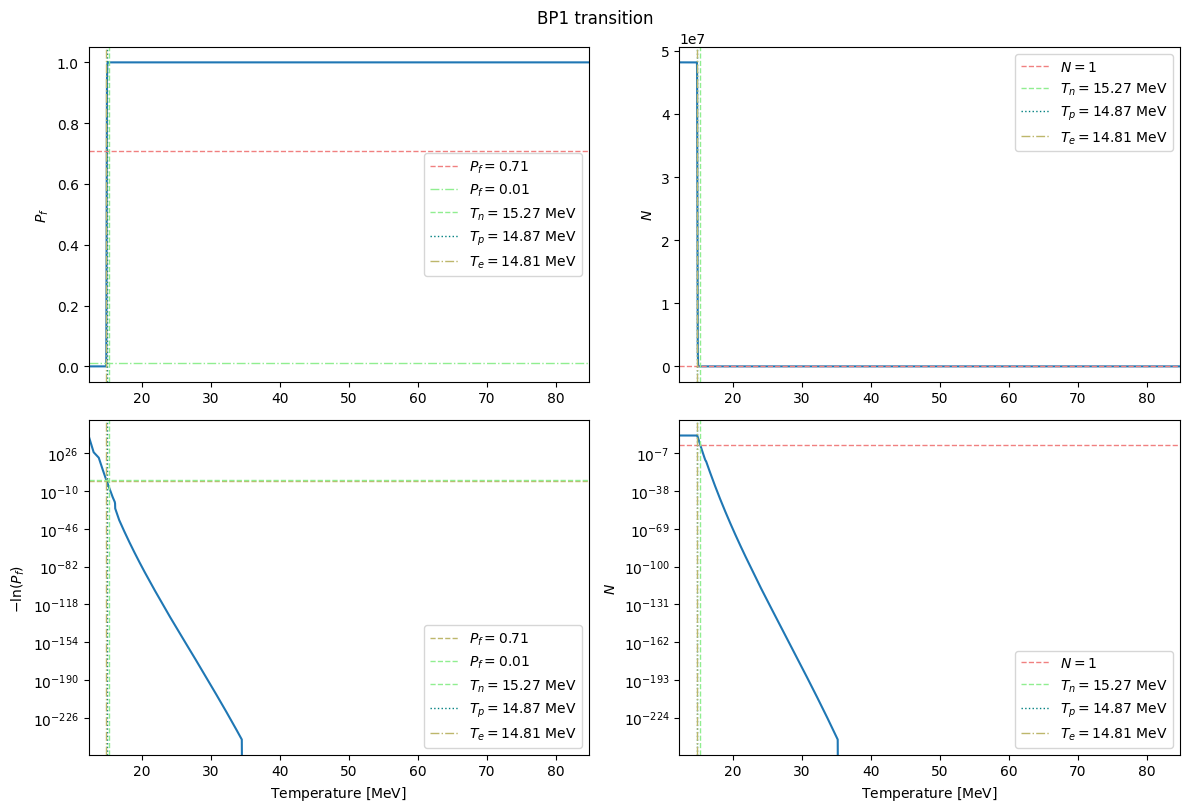

Average number of bubbles at T_min, N = 4.817e+07


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(Temps, np.exp(logP_f))
#axes[0,0].set_title('Fraction of universe in false vacuum')
#axes[0,0].set_xlabel(f'T [{units}]')
axes[0,0].set_ylabel('$P_f$')
axes[0,0].axhline(0.71, color='lightcoral', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[0,0].axhline(0.01, color='lightgreen', linestyle='-.', linewidth=1, label=f'$P_f = 0.01$')
axes[0,0].legend()

axes[0,1].plot(Temps[mask_nH], nH[mask_nH])
axes[0,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[0,1].set_title('Bubbles per Hubble volume')
#axes[0,1].set_xlabel(f'Temperature [{units}]')
axes[0,1].set_ylabel('$N$')
axes[0,1].legend()

axes[1,0].plot(Temps, -logP_f)
axes[1,0].axhline(-np.log(0.71), color='darkkhaki', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[1,0].axhline(-np.log(0.01), color='lightgreen', linestyle='--', linewidth=1, label=f'$P_f = 0.01$')
#axes[1,0].set_title('(minus) Log of fraction of universe in false vacuum')
axes[1,0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel('$-\ln (P_f)$')
axes[1,0].set_yscale('log')
axes[1,0].legend()

axes[1,1].plot(Temps[mask_nH], nH[mask_nH])
axes[1,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[1,1].set_title('Bubbles per Hubble volume')
axes[1,1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel('$N$')
axes[1,1].set_yscale('log')
axes[1,1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
    ax.legend()

for ax in axes.flatten():
    ax.set_xlim(Temps[0], Temps[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.01)
plt.savefig(figure_dir + f"evolution_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Average number of bubbles at T_min, N = {nH[mask_nH][0]:.3e}")


<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\ '
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid e

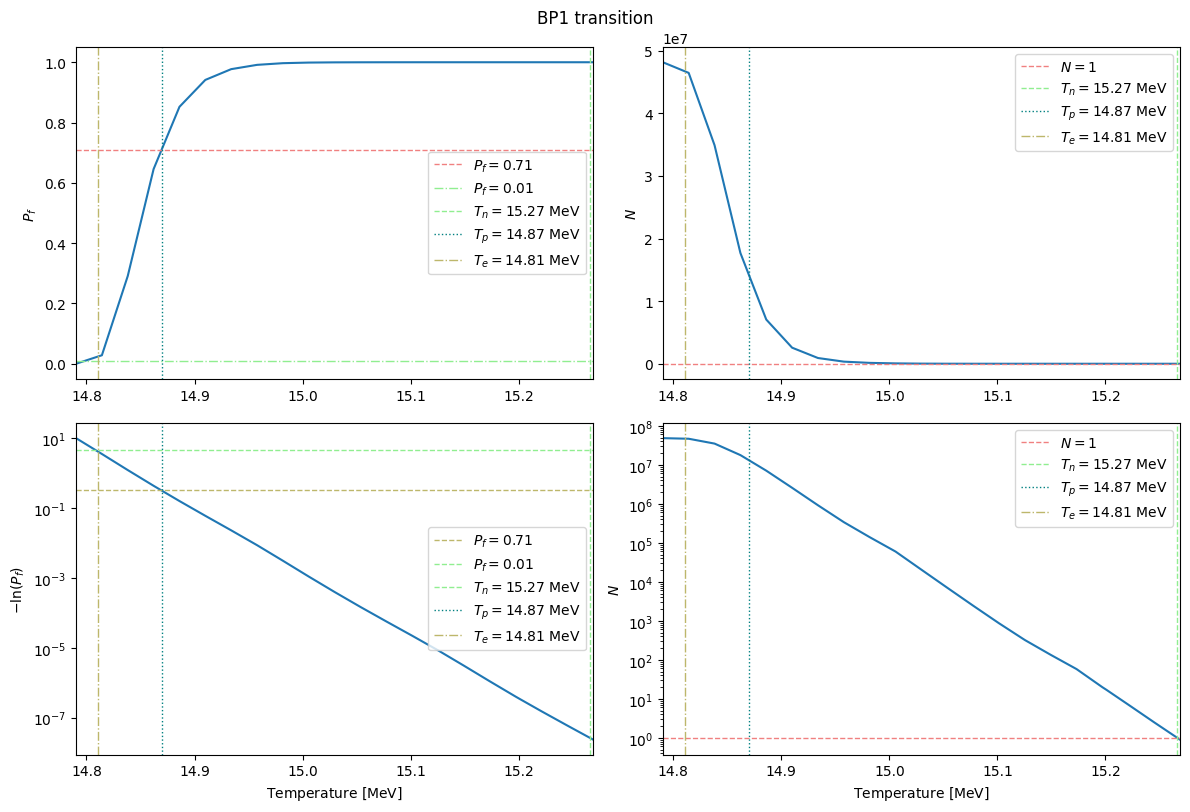

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(Temps[mask], np.exp(logP_f[mask]))
#axes[0,0].set_title('Fraction of universe in false vacuum')
#axes[0,0].set_xlabel(f'T [{units}]')
axes[0,0].set_ylabel('$P_f$')
axes[0,0].axhline(0.71, color='lightcoral', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[0,0].axhline(0.01, color='lightgreen', linestyle='-.', linewidth=1, label=f'$P_f = 0.01$')
axes[0,0].legend()

axes[0,1].plot(Temps[mask], nH[mask])
axes[0,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[0,1].set_title('Bubbles per Hubble volume')
#axes[0,1].set_xlabel(f'Temperature [{units}]')
axes[0,1].set_ylabel('$N$')
axes[0,1].legend()

axes[1,0].plot(Temps[mask], -logP_f[mask])
axes[1,0].axhline(-np.log(0.71), color='darkkhaki', linestyle='--', linewidth=1, label=f'$P_f = 0.71$')
axes[1,0].axhline(-np.log(0.01), color='lightgreen', linestyle='--', linewidth=1, label=f'$P_f = 0.01$')
#axes[1,0].set_title('(minus) Log of fraction of universe in false vacuum')
axes[1,0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel('$-\ln (P_f)$')
axes[1,0].set_yscale('log')
axes[1,0].legend()

axes[1,1].plot(Temps[mask], nH[mask])
axes[1,1].axhline(1, color='lightcoral', linestyle='--', linewidth=1, label=f'$N = 1$')
#axes[1,1].set_title('Bubbles per Hubble volume')
axes[1,1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel('$N$')
axes[1,1].set_yscale('log')
axes[1,1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
    ax.legend()

for ax in axes.flatten():
    ax.set_xlim(Temps[mask][0], Temps[mask][-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.01)
plt.savefig(figure_dir + f"evolution_{description}_zoom.pdf", dpi=300, bbox_inches='tight')
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\ '
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\ '
<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\ '
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid e

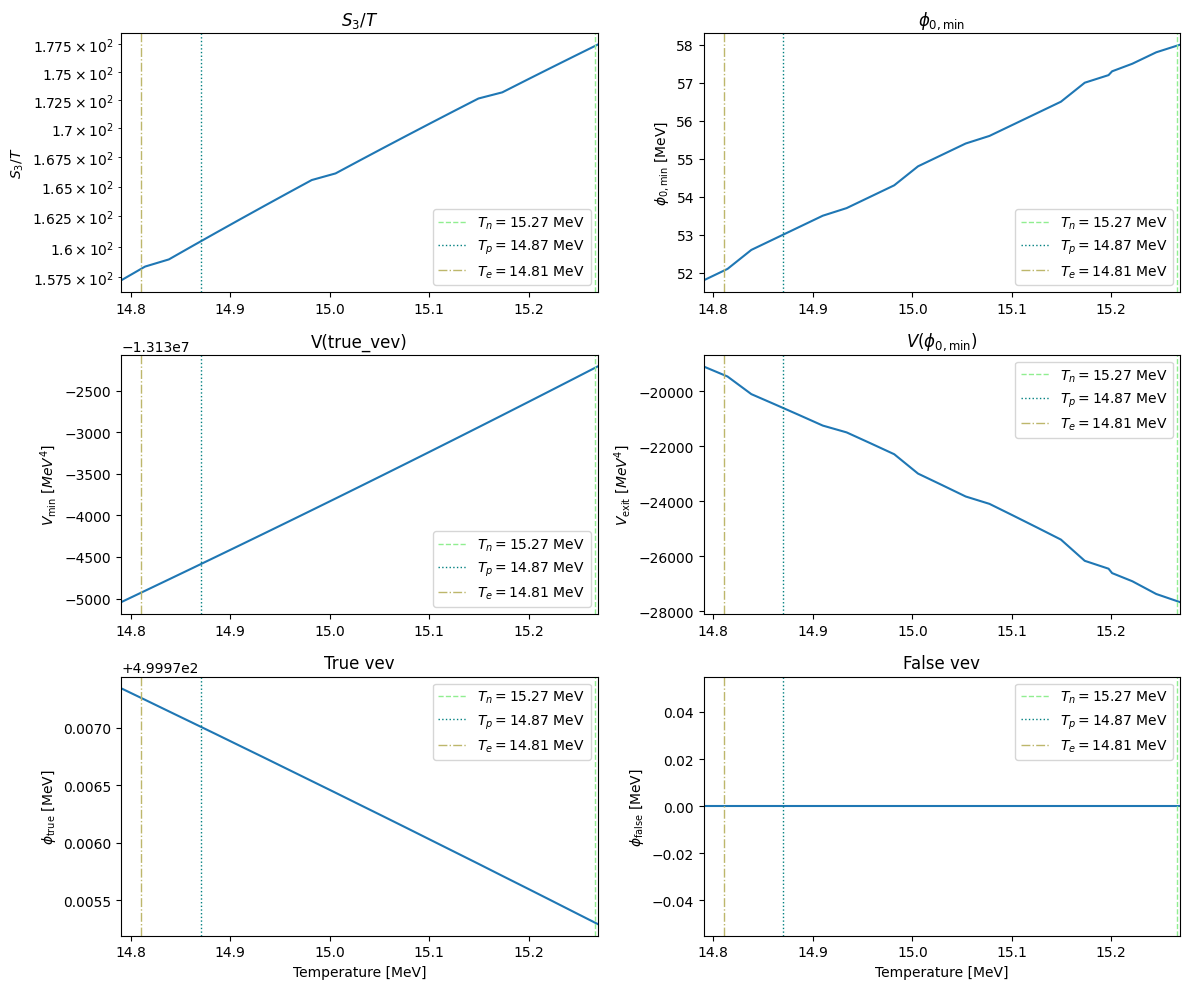

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(Temps[mask], [S3overT[T] for T in Temps[mask]])
axes[0, 0].set_title('$S_3/T$')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('$S_3/T$')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(Temps[mask], [phi0_min[T] for T in Temps[mask]])
axes[0, 1].set_title('$\phi_{0,\mathrm{min}}$')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f'$\\phi_{{0,\\mathrm{{min}}}}$ [{units}]')

axes[1, 0].plot(Temps[mask], [V_min_value[T] for T in Temps[mask]])
axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f'$V_{{\\mathrm{{min}}}}\ [{units}^4]$')

axes[1, 1].plot(Temps[mask], [V_exit[T] for T in Temps[mask]])
axes[1, 1].set_title('$V(\phi_{0,\mathrm{min}})$')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f'$V_{{\\mathrm{{exit}}}}\ [{units}^4]$')

axes[2, 0].plot(Temps[mask], [true_vev[T] for T in Temps[mask]])
axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"Temperature [{units}]")
axes[2, 0].set_ylabel(f'$\\phi_{{\\mathrm{{true}}}}$ [{units}]')

axes[2, 1].plot(Temps[mask], [false_vev[T] for T in Temps[mask]])
axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"Temperature [{units}]")
axes[2, 1].set_ylabel(f'$\\phi_{{\\mathrm{{false}}}}$ [{units}]')

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')
    ax.set_xlim(Temps[mask][0], Temps[mask][-1])
    ax.legend()

plt.tight_layout()
plt.show()


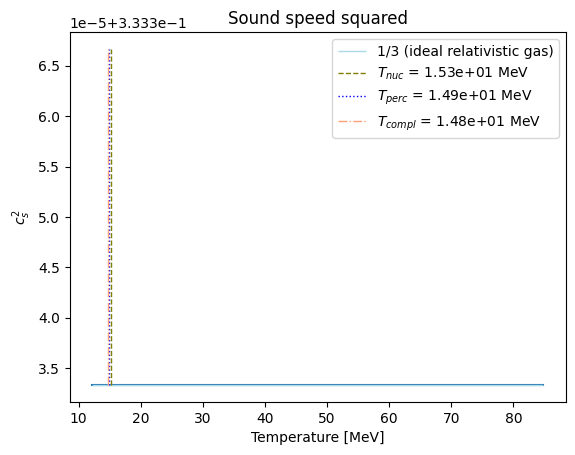

In [27]:
import numpy as np # Ensure numpy is available
from GWparams import cs2 # Keep original import if needed elsewhere, but redefine locally

def cs2_fixed(T_val, model_instance, true_vev_dict, units='GeV'):
    # Ensure true_vev[T_val] is formatted as a 2D array, e.g., [[value]]
    phi_val_array = np.atleast_1d(true_vev_dict[T_val]).reshape(-1, 1)

    # Call the model's dVdT and d2VdT2 methods with the correctly formatted array
    dVdT_val = model_instance.dVdT(phi_val_array, T_val, include_radiation=True, include_SM=True, units=units)
    d2VdT2_val = model_instance.d2VdT2(phi_val_array, T_val, include_radiation=True, include_SM=True, units=units)

    # Calculate speed2, handling potential division by zero or NaN
    if T_val == 0 or d2VdT2_val == 0 or np.isnan(d2VdT2_val) or np.isinf(d2VdT2_val):
        speed2 = np.nan # Return NaN if calculation is problematic
    else:
        speed2 = dVdT_val / (T_val * d2VdT2_val)

    return min(1/3, speed2)

if T_perc is not None:
    action_over_T(T_perc)
    # Use the fixed cs2_fixed function and 'm' as the model instance
    c_s2 = cs2_fixed(T_perc, dp, true_vev, units = units)

y = [cs2_fixed(T, dp, true_vev, units = units) for T in Temps]
plt.plot(Temps, y)
plt.hlines(1/3, Temps[0], Temps[-1], color='lightblue', linestyle='-', linewidth=1, label='1/3 (ideal relativistic gas)')
plt.vlines(T_nuc, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='olive', linestyle='--', linewidth=1, label=f'$T_{{nuc}}$ = {T_nuc:.2e} {units}')
plt.vlines(T_perc, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}}$ = {T_perc:.2e} {units}')
plt.vlines(T_completion, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='lightsalmon', linestyle='-.', linewidth=1, label=f'$T_{{compl}}$ = {T_completion:.2e} {units}')
plt.title('Sound speed squared')
plt.xlabel(f'Temperature [{units}]')
plt.ylabel('$c_s^2$')
plt.legend()
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from GWparams import alpha_th_bar # This is the definition of \alpha
from custom_model import GenericCTModel

def c_alpha_inf(T, dp, units):
    v_true_val = true_vev[T]
    v_false_val = false_vev[T]

    # Ensure v_true and v_false are (1,1) arrays for consistent calculations
    v_true_arr = np.atleast_1d(v_true_val).reshape(-1, 1)
    v_false_arr = np.atleast_1d(v_false_val).reshape(-1, 1)

    # Use dp.g and dp.lam, and reshaped arrays
    Dm2_photon = 3 * dp.g**2 * (v_true_arr**2 - v_false_arr**2)
    Dm2_scalar = 3 * dp.lam * (v_true_arr**2 - v_false_arr**2)
    numerator = (Dm2_photon + Dm2_scalar) * T**2 / 24

    # dp.dVdT expects a (N,1) array, which v_false_arr already is
    rho_tot = - T * 3 * (dp.dVdT(v_false_arr, T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(v_false_arr, T, include_radiation=True, include_SM = False, units = units) ) / 4

    # Handle division by zero or negative density, and convert 1x1 arrays to scalars
    if rho_tot <= 0:
        alpha_inf_tot = np.nan
    else:
        alpha_inf_tot = numerator.item() / rho_tot.item()

    if rho_DS <= 0:
        alpha_inf_DS = np.nan
    else:
        alpha_inf_DS = numerator.item() / rho_DS.item()

    return alpha_inf_tot, alpha_inf_DS

def c_alpha_eq(T, dp, units):
    v_true_val = true_vev[T]
    v_false_val = false_vev[T]

    # Ensure v_true and v_false are (1,1) arrays for consistent calculations
    v_true_arr = np.atleast_1d(v_true_val).reshape(-1, 1)
    v_false_arr = np.atleast_1d(v_false_val).reshape(-1, 1)

    # Use dp.g and reshaped arrays
    numerator = (dp.g**2 * 3 * (dp.g * (v_true_arr - v_false_arr)) * T**3)

    # dp.dVdT expects a (N,1) array, which v_false_arr already is
    rho_tot = - T * 3 * (dp.dVdT(v_false_arr, T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(v_false_arr, T, include_radiation=True, include_SM = False, units = units) ) / 4

    # Handle division by zero or negative density, and convert 1x1 arrays to scalars
    if rho_tot <= 0:
        alpha_eq_tot = np.nan
    else:
        alpha_eq_tot = numerator.item() / rho_tot.item()

    if rho_DS <= 0:
        alpha_eq_DS = np.nan
    else:
        alpha_eq_DS = numerator.item() / rho_DS.item()

    return alpha_eq_tot, alpha_eq_DS


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from GWparams import alpha_th_bar # This is the definition of \alpha
from custom_model import GenericCTModel

def cs2_fixed(T_val, model_instance, true_vev_dict, units='GeV'):
    # Ensure true_vev[T_val] is formatted as a 2D array, e.g., [[value]]
    phi_val_array = np.atleast_1d(true_vev_dict[T_val]).reshape(-1, 1)

    # Call the model's dVdT and d2VdT2 methods with the correctly formatted array
    dVdT_val = model_instance.dVdT(phi_val_array, T_val, include_radiation=True, include_SM=True, units=units)
    d2VdT2_val = model_instance.d2VdT2(phi_val_array, T_val, include_radiation=True, include_SM=True, units=units)

    # Calculate speed2, handling potential division by zero or NaN
    if T_val == 0 or d2VdT2_val == 0 or np.isnan(d2VdT2_val) or np.isinf(d2VdT2_val):
        speed2 = np.nan # Return NaN if calculation is problematic
    else:
        speed2 = dVdT_val / (T_val * d2VdT2_val)

    return min(1/3, speed2)

def cs2_fixed_DS(T_val, model_instance, true_vev_dict, units='GeV'):
    phi_val_array = np.atleast_1d(true_vev_dict[T_val]).reshape(-1, 1)
    dVdT_val = model_instance.dVdT(phi_val_array, T_val, include_radiation=True, include_SM=False, units=units)
    d2VdT2_val = model_instance.d2VdT2(phi_val_array, T_val, include_radiation=True, include_SM=False, units=units)
    if T_val == 0 or d2VdT2_val == 0 or np.isnan(d2VdT2_val) or np.isinf(d2VdT2_val):
        speed2 = np.nan
    else:
        speed2 = dVdT_val / (T_val * d2VdT2_val)
    return min(1/3, speed2)

def alpha_th_bar_fixed(T, m, V_min_value, false_vev_dict, true_vev_dict, units='GeV'):
    false_vev_T_arr = np.atleast_1d(false_vev_dict[T]).reshape(-1, 1)
    true_vev_T_arr = np.atleast_1d(true_vev_dict[T]).reshape(-1, 1)

    # Calculate 'alpha' (total) using SM contributions
    delta_rho_tot = - V_min_value[T] - T * (
        m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=True, units=units) - \
        m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=True, units=units)
    )
    c_s2_tot = cs2_fixed(T, m, true_vev_dict, units=units)
    delta_p_tot = V_min_value[T] / c_s2_tot
    wf_tot = - T * m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=True, units=units)
    w_th_tot = - T * m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=True, units=units)
    alpha_val = (delta_rho_tot - delta_p_tot) / (wf_tot - w_th_tot)

    # Calculate 'alpha_DS' (dark sector only) without SM contributions
    delta_rho_DS = - V_min_value[T] - T * (
        m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=False, units=units) - \
        m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=False, units=units)
    )
    c_s2_DS_val = cs2_fixed_DS(T, m, true_vev_dict, units=units)
    delta_p_DS_val = V_min_value[T] / c_s2_DS_val
    wf_DS = - T * m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=False, units=units)
    w_th_DS = - T * m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=False, units=units)
    alpha_DS_val = (delta_rho_DS - delta_p_DS_val) / (wf_DS - w_th_DS)

    return alpha_val, alpha_DS_val


alpha, alpha_DS = alpha_th_bar_fixed(T_perc, dp, V_min_value, false_vev, true_vev, units = units)
alpha = alpha.item() # Convert to scalar as it's a 1-element array
alpha_inf, alpha_inf_DS = c_alpha_inf(T_perc, dp, units)
# alpha_inf is already a float from c_alpha_inf, no .item() needed
alpha_eq, alpha_eq_DS = c_alpha_eq(T_perc, dp, units)
# alpha_eq is already a float from c_alpha_eq, no .item() needed

gamma_eq = (alpha - alpha_inf) / alpha_eq
# gamma_eq will be a scalar because alpha, alpha_inf, alpha_eq are now all scalars. No .item() needed.

print(f"alpha = {alpha}")
print(f"alpha_inf = {alpha_inf}")
print(f"alpha_eq = {alpha_eq}")
print(f"gamma_eq = {gamma_eq}")

if alpha < alpha_inf:
    is_physical = False
    print("\n*** Warning, the bubble expansion is not in runaway regime! The results of the computation are not reliable ***")

v_min = 0.99

if gamma_eq < 1 / np.sqrt(1 - v_min**2):
    is_physical = False
    print(f"\n*** Warning, the NLO pressure could prevent the walls to reach relativistic velocities (gamma_eq = {gamma_eq:.2e}). The results of the computation are not reliable ***")


alpha = 614.7870799117102
alpha_inf = 7.619613568277451
alpha_eq = 2.9205014266357896
gamma_eq = 207.898363207734


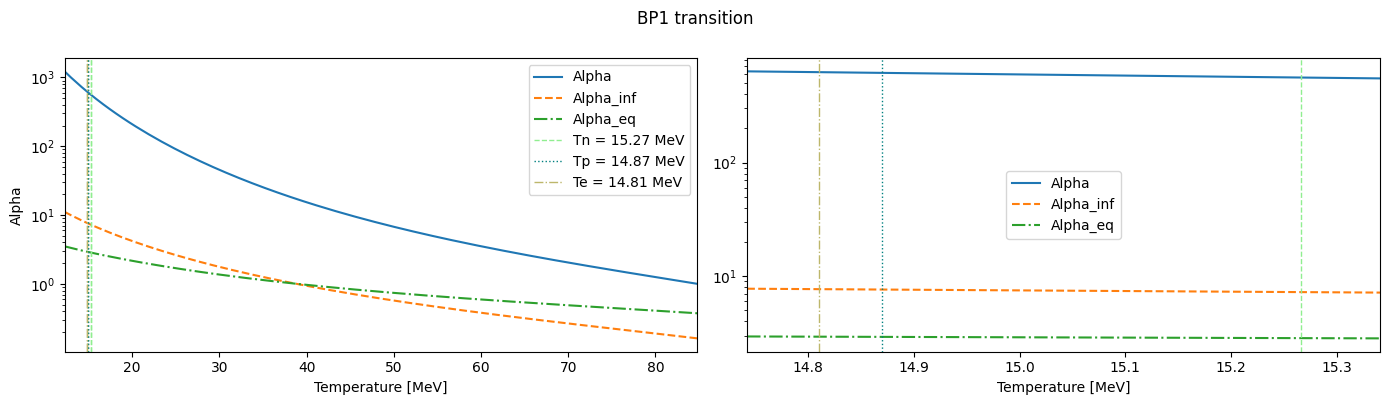

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Explicitly disable LaTeX rendering to prevent ParseException
plt.rcParams['text.usetex'] = False

# Redefine alpha_th_bar locally to ensure proper array reshaping for dVdT calls
def alpha_th_bar_fixed(T, m, V_min_value, false_vev_dict, true_vev_dict, units='GeV'):
    # Ensure field values are 1D arrays
    false_vev_T_arr = np.atleast_1d(false_vev_dict[T]).reshape(-1, 1)
    true_vev_T_arr = np.atleast_1d(true_vev_dict[T]).reshape(-1, 1)

    # Calculate 'alpha' (total) using SM contributions
    delta_rho_tot = - V_min_value[T] - T * (
        m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=True, units=units) - \
        m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=True, units=units)
    )
    c_s2_tot = cs2_fixed(T, m, true_vev_dict, units=units)
    delta_p_tot = V_min_value[T] / c_s2_tot
    wf_tot = - T * m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=True, units=units)
    w_th_tot = - T * m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=True, units=units)
    alpha_val = (delta_rho_tot - delta_p_tot) / (wf_tot - w_th_tot)

    # Calculate 'alpha_DS' (dark sector only) without SM contributions
    delta_rho_DS = - V_min_value[T] - T * (
        m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=False, units=units) - \
        m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=False, units=units)
    )
    c_s2_DS_val = cs2_fixed_DS(T, m, true_vev_dict, units=units)
    delta_p_DS_val = V_min_value[T] / c_s2_DS_val
    wf_DS = - T * m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM=False, units=units)
    w_th_DS = - T * m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM=False, units=units)
    alpha_DS_val = (delta_rho_DS - delta_p_DS_val) / (wf_DS - w_th_DS)

    return alpha_val, alpha_DS_val


# Ensure alpha_T, alpha_inf_T, alpha_eq_T are properly defined
alpha_T = np.array([alpha_th_bar_fixed(T, dp, V_min_value, false_vev, true_vev, units)[0] for T in Temps])
alpha_inf_T = np.array([c_alpha_inf(t, dp, units)[0] for t in Temps]) # Corrected indexing
alpha_eq_T = np.array([c_alpha_eq(t, dp, units)[0] for t in Temps]) # Corrected indexing

# Re-create mask to ensure it is consistent with the current Temps length
# This section ensures 'mask' is consistent with 'Temps' when used for indexing.
t_mil_min = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max = np.nanmax([T_completion, T_perc, T_nuc])

# Handle cases where min/max might be NaN if T_nuc, T_perc, T_completion are all NaN
if np.isnan(t_mil_min) or np.isnan(t_mil_max):
    # If no valid milestones (e.g., all T_nuc, T_perc, T_completion are NaN), use full range
    mask = np.ones_like(Temps, dtype=bool)
else:
    # Ensure indices are within bounds
    i0 = max(int(np.argmin(np.abs(Temps - t_mil_min))) - 3, 0)
    i1 = min(int(np.argmin(np.abs(Temps - t_mil_max))) + 3, len(Temps)-1)
    mask = np.zeros_like(Temps, dtype=bool)
    mask[i0:i1+1] = True

# Define a small positive floor for log plotting, and handle NaN/inf
plot_floor = 1e-100 # A very small positive number
def _log_plot_safe(arr):
    arr = np.asarray(arr, dtype=float)
    arr[np.isnan(arr)] = plot_floor # Replace NaN with floor
    arr[arr <= 0] = plot_floor # Replace non-positive with floor
    arr[np.isinf(arr)] = plot_floor # Replace inf with floor
    return arr

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(Temps, _log_plot_safe(alpha_T), linestyle='-', label='Alpha')
axes[0].plot(Temps, _log_plot_safe(alpha_inf_T), linestyle='--', label='Alpha_inf')
axes[0].plot(Temps, _log_plot_safe(alpha_eq_T),  linestyle='-.', label='Alpha_eq')
axes[0].axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'Tn = {T_nuc:.2f} {units}')
axes[0].axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'Tp = {T_perc:.2f} {units}')
axes[0].axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'Te = {T_completion:.2f} {units}')
axes[0].set_xlabel(f"Temperature [{units}]")
axes[0].set_ylabel('Alpha')
axes[0].set_yscale('log')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].legend()


axes[1].plot(Temps[mask], _log_plot_safe(alpha_T[mask]), label='Alpha', linestyle='-')
axes[1].plot(Temps[mask], _log_plot_safe(alpha_inf_T[mask]), label='Alpha_inf', linestyle='--')
axes[1].plot(Temps[mask], _log_plot_safe(alpha_eq_T[mask]), label='Alpha_eq', linestyle='-.')
axes[1].set_xlabel(f"Temperature [{units}]")
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

y_data_masked = np.concatenate([_log_plot_safe(alpha_T[mask]).flatten(), _log_plot_safe(alpha_inf_T[mask]).flatten(), _log_plot_safe(alpha_eq_T[mask]).flatten()])
y_data_masked_positive = y_data_masked[y_data_masked > plot_floor]

if len(y_data_masked_positive) > 1 and np.nanmax(y_data_masked_positive) > np.nanmin(y_data_masked_positive):
    axes[1].set_yscale('log')
else:
    axes[1].set_yscale('linear')
    axes[1].set_ylim(bottom=0)

axes[1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'Tn = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'Tp = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'Te = {T_completion:.2f} {units}')

fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"alpha_{description}.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [32]:
from temperatures import R_sepH
import numpy as np # Import numpy for np.interp

RH, R = R_sepH(Temps, Gamma, logP_f, H, ratio_V)
# Replace interpolation_narrow with np.interp for linear interpolation
RH_interp = np.interp(T_perc, Temps, RH)
H_star = np.interp(T_perc, Temps, H)
R_star = RH_interp / H_star

print(f"R* H* = {RH_interp:.2e}")

R* H* = 6.95e-03


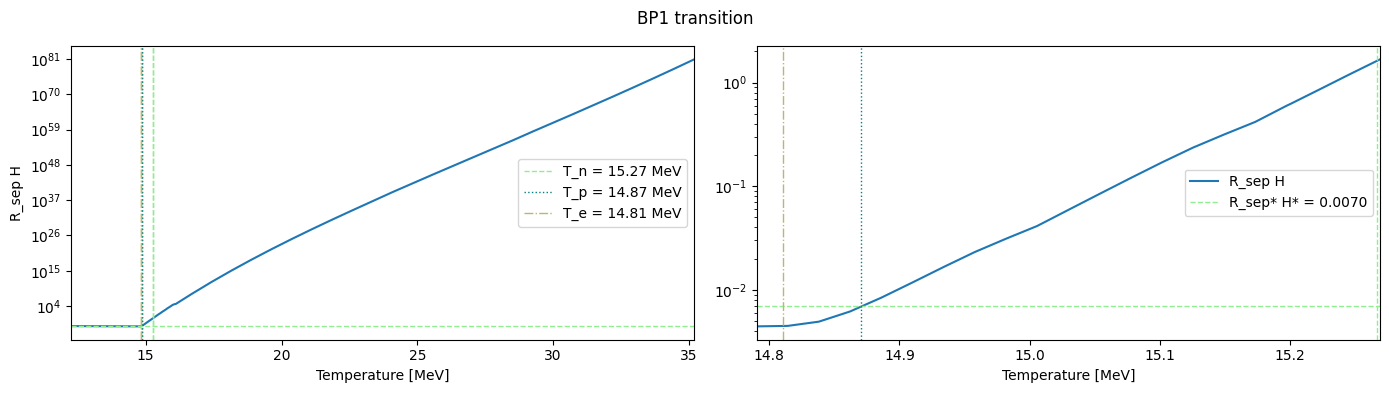

In [33]:
import matplotlib.pyplot as plt
import numpy as np


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# First plot (full RH plot)
axes[0].plot(Temps, RH)
axes[0].set_ylabel('R_sep H')
axes[0].set_yscale('log')
axes[0].axhline(RH_interp, color='lightgreen', linestyle='--', linewidth=1)
axes[0].axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'T_n = {T_nuc:.2f} {units}')
axes[0].axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'T_p = {T_perc:.2f} {units}')
axes[0].axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'T_e = {T_completion:.2f} {units}')
axes[0].set_xlim(Temps[0], Temps[np.max(np.where(RH < np.inf)[0])])
axes[0].legend()

# Second plot (masked RH plot)
# Re-calculate mask based on milestones to ensure it covers a valid range
t_mil_min_plot = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max_plot = np.nanmax([T_completion, T_perc, T_nuc])

# Extend the range slightly for better visualization
padding = 0.05 * (t_mil_max_plot - t_mil_min_plot)
if np.isnan(padding):
    # Fallback if milestones are too close or NaN
    padding = 0.05 * (Temps[-1] - Temps[0]) # Use overall range

mask = (Temps >= t_mil_min_plot - padding) & (Temps <= t_mil_max_plot + padding)

# Ensure mask is not empty; if it is, fall back to a default reasonable range or full range
if not np.any(mask) and Temps.size > 0:
    # If the computed mask is still empty, try to ensure at least some points are covered
    center_T = T_perc if np.isfinite(T_perc) else np.mean(Temps)
    range_T = Temps[-1] - Temps[0]
    if range_T == 0: # Handle case of single point or all same temps
        mask = (Temps == center_T)
    else:
        mask = (Temps >= center_T - 0.1 * range_T) & (Temps <= center_T + 0.1 * range_T)
    if not np.any(mask):
        mask = np.ones_like(Temps, dtype=bool) # Fallback to full range if all else fails

# Plot only if the mask selects valid points
if np.any(mask):
    axes[1].plot(Temps[mask], RH[mask], label='R_sep H')
    axes[1].set_yscale('log')
    axes[1].axhline(RH_interp, color='lightgreen', linestyle='--', linewidth=1, label=f'R_sep* H* = {RH_interp:.4f}')
    axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])
    axes[1].legend()
else:
    axes[1].set_title("No data in masked range")

# Add vertical lines to both plots for nucleation, percolation, and completion temperatures
for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'T_n = {T_nuc:.2e} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'T_p = {T_perc:.2e} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'T_e = {T_completion:.2e} {units}')
    ax.set_xlabel(f"Temperature [{units}]")

fig.suptitle(f'{description} transition', y=0.97)

# Save and show the plot
plt.savefig("RH_transition.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [34]:
T_perc

np.float64(14.870309585093166)

<>:46: SyntaxWarning: invalid escape sequence '\g'
<>:47: SyntaxWarning: invalid escape sequence '\g'
<>:50: SyntaxWarning: invalid escape sequence '\g'
<>:71: SyntaxWarning: invalid escape sequence '\g'
<>:72: SyntaxWarning: invalid escape sequence '\g'
<>:86: SyntaxWarning: invalid escape sequence '\m'
<>:86: SyntaxWarning: invalid escape sequence '\ '
<>:87: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\ '
<>:88: SyntaxWarning: invalid escape sequence '\m'
<>:88: SyntaxWarning: invalid escape sequence '\ '
<>:89: SyntaxWarning: invalid escape sequence '\g'
<>:90: SyntaxWarning: invalid escape sequence '\g'
<>:98: SyntaxWarning: invalid escape sequence '\g'
<>:46: SyntaxWarning: invalid escape sequence '\g'
<>:47: SyntaxWarning: invalid escape sequence '\g'
<>:50: SyntaxWarning: invalid escape sequence '\g'
<>:71: SyntaxWarning: invalid escape sequence '\g'
<>:72: SyntaxWarning: invalid escape sequence '\g'
<>:86: SyntaxWarning: invalid e

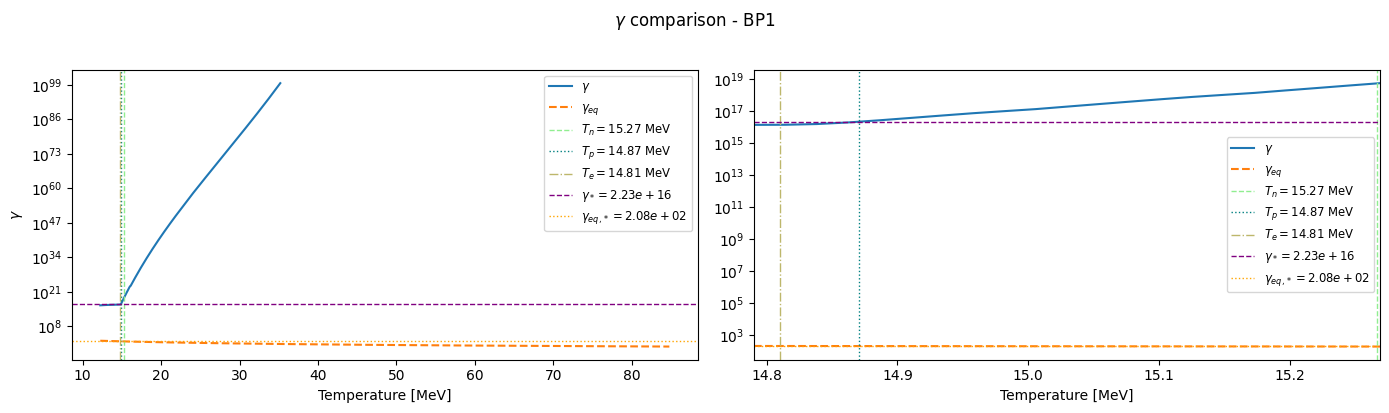

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from temperatures import R0 # Import R0 from temperatures

# Explicitly disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# 1. Calculate r0
r0 = np.array([R0(T, S3overT, V_exit) for T in Temps])

# 2. Recalculate alpha_T_1d, alpha_inf_T_1d, alpha_eq_T_1d
# Ensure to extract the first element [0] from the results as per instructions and convert to scalar float
alpha_T_1d = np.array([float(alpha_th_bar_fixed(T, dp, V_min_value, false_vev, true_vev, units)[0]) for T in Temps])
alpha_inf_T_1d = np.array([float(c_alpha_inf(t, dp, units)[0]) for t in Temps])
alpha_eq_T_1d = np.array([float(c_alpha_eq(t, dp, units)[0]) for t in Temps])

# 3. Calculate gamma_eq_T
# Handle potential division by zero if alpha_eq_T contains zeros or NaNs
with np.errstate(divide='ignore', invalid='ignore'):
    gamma_eq_T = (alpha_T_1d - alpha_inf_T_1d) / alpha_eq_T_1d
    gamma_eq_T[np.isinf(gamma_eq_T)] = np.nan # Replace inf with nan
    gamma_eq_T[alpha_eq_T_1d == 0] = np.nan # Handle explicit zero division

# 4. Calculate gamma
# Handle potential division by zero for r0
with np.errstate(divide='ignore', invalid='ignore'):
    gamma = 2 * R / (3 * r0)
    gamma[r0 == 0] = np.nan # Handle explicit zero division

# Re-calculate R_star and H_star which were missing in the previous context
# RH and H are defined in the kernel from a previous cell, used by np.interp
H_star = np.interp(T_perc, Temps, H) # H is defined from compute_logP_f
RH_interp = np.interp(T_perc, Temps, RH) # RH is defined from R_sepH
R_star = RH_interp / H_star

# 5. Calculate gamma_star
gamma_star = 2 * R_star / (3 * R0(T_perc, S3overT, V_exit))

# 6. Calculate gamma_eq_star
gamma_eq_star = np.interp(T_perc, Temps, gamma_eq_T) # gamma_eq_T is now guaranteed to be 1D

# 7. Create the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 8. Plot on the first subplot (axes[0])
axes[0].plot(Temps, gamma, label='$\gamma$')
axes[0].plot(Temps, gamma_eq_T, label='$\gamma_{eq}$', linestyle='--') # Use linestyle for differentiation
axes[0].set_yscale('log')
axes[0].set_xlabel(f'Temperature [{units}]')
axes[0].set_ylabel('$\gamma$')
axes[0].legend()

# 9. Plot on the second subplot (axes[1])
# Re-create mask to ensure it is consistent with the current Temps length (from previous cell)
t_mil_min_plot = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max_plot = np.nanmax([T_completion, T_perc, T_nuc])
padding = 0.05 * (t_mil_max_plot - t_mil_min_plot) if not np.isnan(t_mil_max_plot - t_mil_min_plot) else 0.05 * (Temps[-1] - Temps[0])

mask = (Temps >= t_mil_min_plot - padding) & (Temps <= t_mil_max_plot + padding)
if not np.any(mask) and Temps.size > 0:
    center_T = T_perc if np.isfinite(T_perc) else np.mean(Temps)
    range_T = Temps[-1] - Temps[0]
    if range_T == 0:
        mask = (Temps == center_T)
    else:
        mask = (Temps >= center_T - 0.1 * range_T) & (Temps <= center_T + 0.1 * range_T)
    if not np.any(mask):
        mask = np.ones_like(Temps, dtype=bool)

if np.any(mask):
    axes[1].plot(Temps[mask], gamma[mask], label='$\gamma$')
    axes[1].plot(Temps[mask], gamma_eq_T[mask], label='$\gamma_{eq}$', linestyle='--') # Use linestyle
    axes[1].set_yscale('log')
    axes[1].set_xlabel(f'Temperature [{units}]')
    axes[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])
else:
    axes[1].set_title("No data in masked range")
    axes[1].set_xlabel(f'Temperature [{units}]')
    # Still add legends if no data, to show milestones and values
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

# 10. Add vertical and horizontal lines for critical temperatures to both subplots
for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_n = {T_nuc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_p = {T_perc:.2f} \mathrm{{\ {units}}}$')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_e = {T_completion:.2f} \mathrm{{\ {units}}}$')
    ax.axhline(gamma_star, color='purple', linestyle='--', linewidth=1, label=f'$\gamma_* = {gamma_star:.2e}$')
    ax.axhline(gamma_eq_star, color='orange', linestyle=':', linewidth=1, label=f'$\gamma_{{eq,*}} = {gamma_eq_star:.2e}$')
    # Re-add legend here to include the lines, or update existing legend
    handles, labels = ax.get_legend_handles_labels()
    # Filter out duplicate labels if they are added in each iteration of axvline/axhline
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='best', fontsize='small')

# 11. Title for the figure
fig.suptitle(f'$\gamma$ comparison - {description}', y=1.02)

# 12. Adjust the layout
plt.tight_layout()

# 13. Display the plot
plt.savefig(figure_dir + f"gamma_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [36]:
from GWparams import beta
import temperatures as temp # Import the temperatures module to access compute_logP_f

logP_f, Temps, ratio_V, Gamma, H = temp.compute_logP_f(dp, V_min_value, S3overT, v_w = 1, units = units, cum_method= 'None')

beta_Hn, gamma_Hn, times, Gamma_t, Temps_t, H_t = beta(Temps, ratio_V, Gamma, H, T_nuc, T_perc, verbose = True)

# delta = (T_nuc - T_perc) / 2
# beta_Hn, gamma_Hn, times, Gamma_t, Temps_t, H_t = beta(Temps, ratio_V, Gamma, H, T_perc + delta, T_perc - delta, verbose = True)

print("beta =", beta_Hn)
print("gamma =", gamma_Hn)

beta = 635.720735663487
gamma = 14.588880490839793


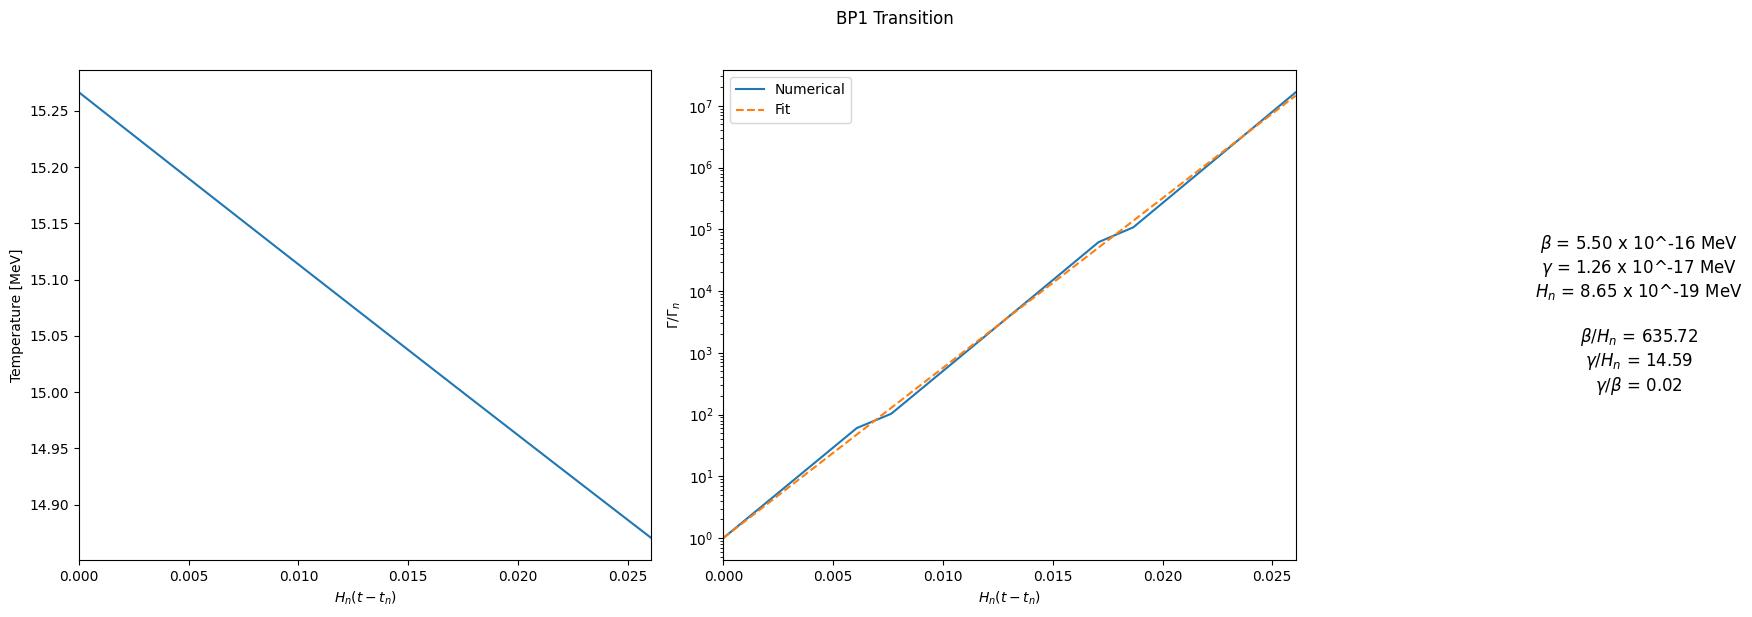

Percolation at 2.61e-02


In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming values for times, Temps_t, Gamma_t, beta_Hn, gamma_Hn, and units are already defined

Gamma_n = Gamma_t[0]
H_n = H_t[0]

def scientific_notation(number):
    """ Return a string formatted in scientific notation with double caret for LaTeX. """
    exponent = int(np.floor(np.log10(abs(number))))
    coefficient = number / 10**exponent
    return f"{coefficient:.2f} x 10^{exponent}"


# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the temperature evolution
axes[0].plot(times, Temps_t)
axes[0].set_xlabel(r"$H_n (t - t_n)$")
axes[0].set_ylabel(f"Temperature [{units}]")
axes[0].set_xlim(times[0], times[-1])

# Prepare the text box to display parameter values
box_text = (
    f"$\\beta$ = {scientific_notation(beta_Hn * H_n)} {units}\n"
    f"$\\gamma$ = {scientific_notation(gamma_Hn * H_n)} {units}\n"
    f"$H_n$ = {scientific_notation(H_n)} {units}\n\n"
    f"$\\beta / H_n$ = {beta_Hn:.2f}\n"
    f"$\\gamma / H_n$ = {gamma_Hn:.2f}\n"
    f"$\\gamma / \\beta$ = {gamma_Hn / beta_Hn:.2f}"
)

# Plotting Gamma values and the fit
axes[1].plot(times, Gamma_t / Gamma_t[0], label="Numerical")
tfit = np.linspace(times[0], times[-1], 100, endpoint=True)
axes[1].plot(tfit, np.exp(beta_Hn * tfit - (gamma_Hn * tfit) ** 2 / 2), label="Fit", linestyle='--')
axes[1].set_xlabel(r"$H_n (t - t_n)$")
axes[1].set_ylabel(r"$\Gamma / \Gamma_n$")
axes[1].set_yscale('log')
axes[1].set_xlim(times[0], times[-1])

# Adding the parameter box on the plot using $$ for LaTeX-friendly format
axes[1].text(1.6, 0.5, box_text,       # coordinates (0-1 for normalized)
             fontsize='large',
             transform=axes[1].transAxes,  # use normalized coordinates
             horizontalalignment='center', # center text horizontally
             verticalalignment='center')   # center text vertically

axes[1].legend()

# Title and layout
plt.suptitle(f'{description} Transition', y=1.02)
plt.tight_layout()

# Saving the figure to a file
plt.savefig(figure_dir + f"nucleation_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Percolation at {times[-1]:.2e}")


In [38]:
from google.colab import files

uploaded = files.upload()

Saving NG15.pkl to NG15.pkl


In [39]:
import matplotlib.pyplot as plt

plt.ion()          # re-enable interactive plotting
plt.close("all")   # clean broken figures


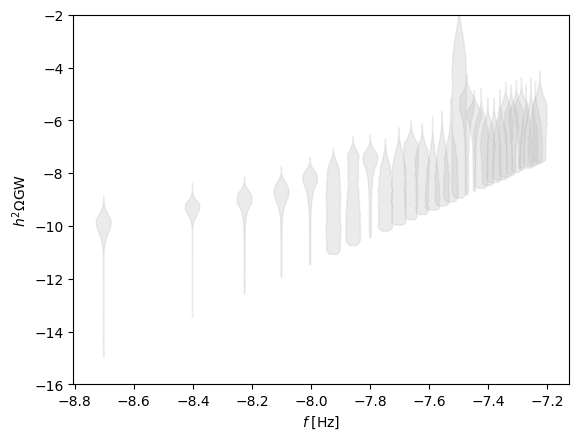

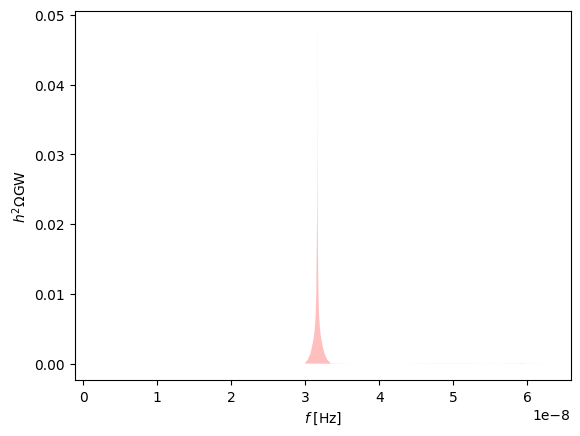

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pkl_path = "NG15.pkl"

with open(pkl_path, "rb") as f:
    fig, ax = pickle.load(f)

fig_linear, ax_linear = plt.subplots(figsize=fig.get_size_inches())

for collection in ax.collections:
    if hasattr(collection, "get_paths") and len(collection.get_paths()) > 0:
        path = collection.get_paths()[0]
        vertices = path.vertices

        if len(vertices) > 0:
            x_log = vertices[:, 0]
            y_log = vertices[:, 1]

            x_linear = 10**x_log
            y_linear = 10**y_log

            ax_linear.fill(
                x_linear,
                y_linear,
                facecolor="red",        # <-- force red
                edgecolor="none",       # cleaner for papers
                alpha=0.25,             # good transparency
            )

ax_linear.set_xscale("linear")
ax_linear.set_yscale("linear")
ax_linear.set_xlabel(ax.get_xlabel())
ax_linear.set_ylabel(ax.get_ylabel())
ax_linear.set_title(ax.get_title())

plt.show()


In [41]:
x=(alpha+1)**(1/4)

In [42]:
T_reh=x*T_perc

Is physical? True
lambda = 0.00165
g = 0.54
vev = 500.0 MeV
m_phi = 28.722813232690143 MeV
m_Z = 270.0 MeV
T_crit = 84.82499999999999 MeV
T_nuc = 15.266470169380028 MeV
T_perc = 14.870309585093166 MeV
T_completion = 14.810471534338843 MeV
T_min = 11.49736886668905 MeV
T_reh = 74.07602222792936 MeV
Minimal value of P_f = 0.0
alpha = 614.7870799117102, alpha_inf = 7.619613568277451, alpha_eq = 2.9205014266357896
gamma_* = 2.2334844297591176e+16, gamma_eq = 207.898363207734
Is runaway? True
RH = 0.006954092395167329


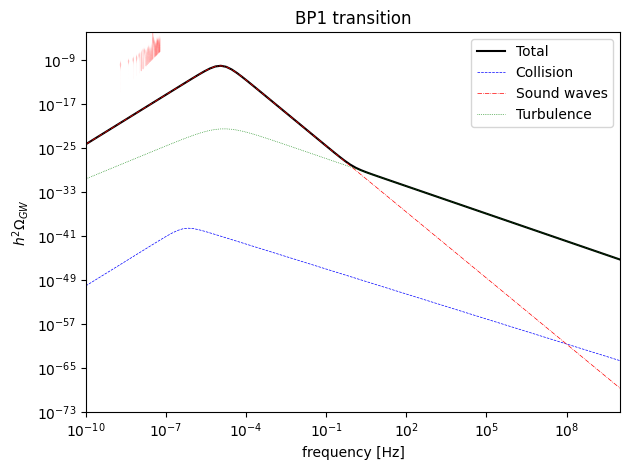

In [43]:
import pickle
from GWparams import GW_SuperCooled
import contextlib
import os # Import the os module

def print_params():
    print(f"Is physical? {is_physical}")
    print(f"lambda = {lambdaf}")
    print(f"g = {gX}")
    print(f"vev = {vev} {units}")
    print(f"m_phi = {np.sqrt(2*lambdaf)*vev} {units}")
    print(f"m_Z = {gX*vev} {units}")
    print(f"T_crit = {T_max} {units}")
    print(f"T_nuc = {T_nuc} {units}")
    print(f"T_perc = {T_perc} {units}")
    print(f"T_completion = {T_completion} {units}")
    print(f"T_min = {T_min} {units}")
    print(f"T_reh = {T_reh} {units}")
    print(f"Minimal value of P_f = {np.nanmin(np.exp(logP_f))}")
    print(f"alpha = {alpha}, alpha_inf = {alpha_inf}, alpha_eq = {alpha_eq}")
    print(f"gamma_* = {gamma_star}, gamma_eq = {gamma_eq}")
    print(f"Is runaway? {alpha > alpha_inf}")
    print(f"RH = {R_star * H_star}")
    #print(f"beta/H_n = {beta_H0}, gamma/H_n = {gamma_H0}, gamma/beta = {gamma_H0/beta_H0}")

# Ensure the figure directory exists (already done in other cells, but good practice)
os.makedirs(figure_dir, exist_ok=True)

# Save the relevant reults to a file
with open(os.path.join(figure_dir, f'{description}.txt'), 'w') as f:
    with contextlib.redirect_stdout(f):
        print_params()

log_freq_min = -10
log_freq_max = 10

if T_perc is not None:
    inst = GW_SuperCooled(T_perc, alpha, alpha_inf, alpha_eq, R_star, gamma_star, H_star, c_s = np.sqrt(c_s2), units = units)
    print_params()

    x = np.linspace(log_freq_min, log_freq_max, 100)
    x = 10**x
    ax_linear.plot(x, inst.Omegah2(x), label = "Total", color='black')
    ax_linear.plot(x, inst.Omegah2coll(x), label = "Collision", linewidth=0.5, color='blue', linestyle='--')
    ax_linear.plot(x, inst.Omegah2sw(x), label = "Sound waves", linewidth=0.5, color='red', linestyle='-.')
    ax_linear.plot(x, inst.Omegah2turb(x), label = "Turbulence", linewidth=0.5, color='green', linestyle=':')
    ax_linear.set_xlim(x[0], x[-1])
    ax_linear.set_ylim(1e-73, 1e-4)
    ax_linear.set_xscale('log')
    ax_linear.set_yscale('log')
    ax_linear.set_xlabel('frequency [Hz]')
    ax_linear.set_ylabel('$h^2 \Omega_{GW}$')
    #plt.title(f'GW spectrum - {description}')
    ax_linear.legend()
    ax_linear.set_title(f'{description} transition', y=1)
    fig_linear.savefig(figure_dir + f"GW_{description}.pdf", dpi=300, bbox_inches='tight')
    fig_linear.tight_layout()

# Save the for spectrum future plotting
if is_physical:
    with open(os.path.join(figure_dir, f'GW_{description}.pkl'), 'wb') as f: # Use os.path.join here as well
        pickle.dump(inst, f)

fig_linear

In [77]:
figure_dir = 'figures/'
description = 'BP1'

import os
os.makedirs(figure_dir, exist_ok=True)

print(f"figure_dir: {figure_dir}")
print(f"description: {description}")

figure_dir: figures/
description: BP1
